In [24]:
import numpy as np
from readlif.reader import LifFile
from skimage import filters, morphology, measure
from skimage.feature import canny
from scipy.ndimage import gaussian_filter
from skan import csr, Skeleton, summarize
from scipy.spatial import distance
import matplotlib.pyplot as plt

In [8]:
# Load the LIF file
lif_file_path = r"C:\Users\vrumst52\Downloads\SproutsForJoppe.lif"  # Update with your path
lif_file = LifFile(lif_file_path)

In [9]:
# Get the desired image series (series_index)
series_index = 1  # Select the series you want to process
series = lif_file.get_image(series_index)

In [10]:
# Get the total number of Z slices (frames) in the series
num_z_slices = series.dims.z  # Number of Z slices
print(f"Total Z slices: {num_z_slices}")

Total Z slices: 41


In [15]:
# Extract a specific Z-slice for visualization
z_slice_index = 25  # Choose any Z-slice to visualize
z_slice = series.get_frame(z=z_slice_index, t=0, c=0)  # Assume single time point and channel


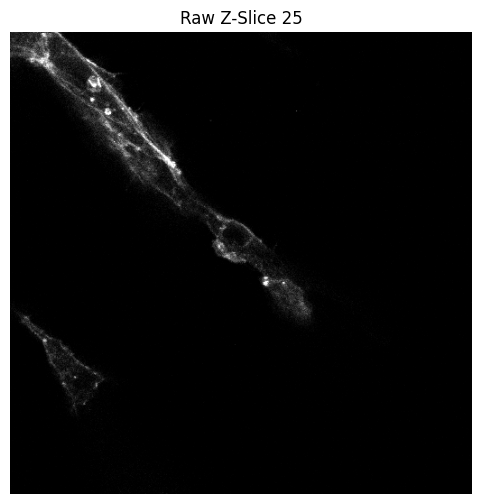

In [16]:
# Plot the raw Z-slice
plt.figure(figsize=(6, 6))
plt.imshow(z_slice, cmap='gray')
plt.title(f"Raw Z-Slice {z_slice_index}")
plt.axis('off')
plt.show()

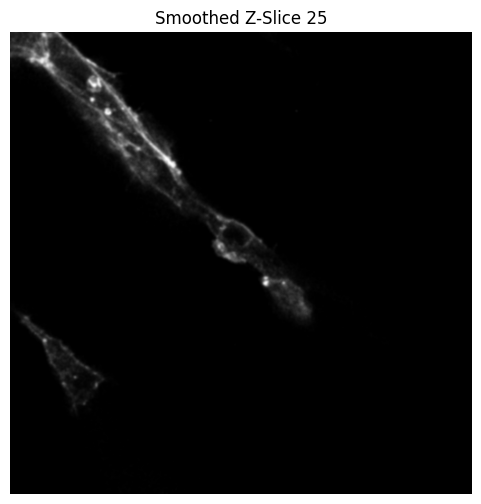

In [17]:
# Apply Gaussian filter to smooth the image
smoothed_slice = gaussian_filter(z_slice, sigma=1)

# Plot the smoothed Z-slice
plt.figure(figsize=(6, 6))
plt.imshow(smoothed_slice, cmap='gray')
plt.title(f"Smoothed Z-Slice {z_slice_index}")
plt.axis('off')
plt.show()

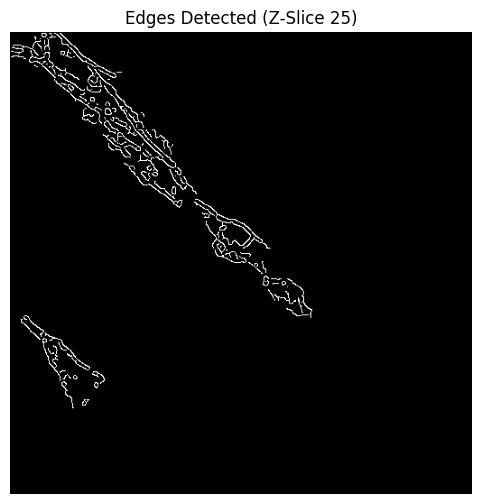

In [18]:
# Apply Canny edge detection
edges = canny(smoothed_slice)

# Plot the detected edges
plt.figure(figsize=(6, 6))
plt.imshow(edges, cmap='gray')
plt.title(f"Edges Detected (Z-Slice {z_slice_index})")
plt.axis('off')
plt.show()

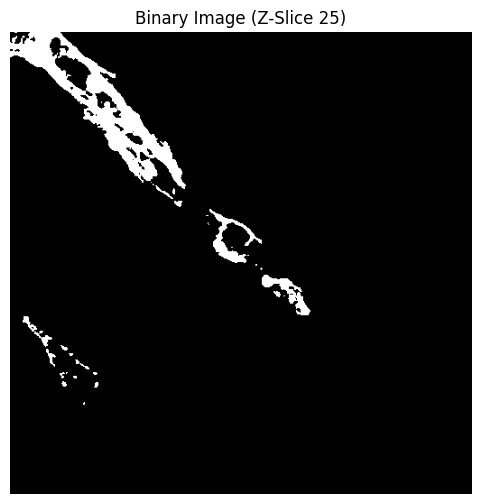

In [19]:
# Apply Otsu's thresholding
threshold_value = filters.threshold_otsu(smoothed_slice)
binary_image = smoothed_slice > threshold_value

# Plot the binary image
plt.figure(figsize=(6, 6))
plt.imshow(binary_image, cmap='gray')
plt.title(f"Binary Image (Z-Slice {z_slice_index})")
plt.axis('off')
plt.show()

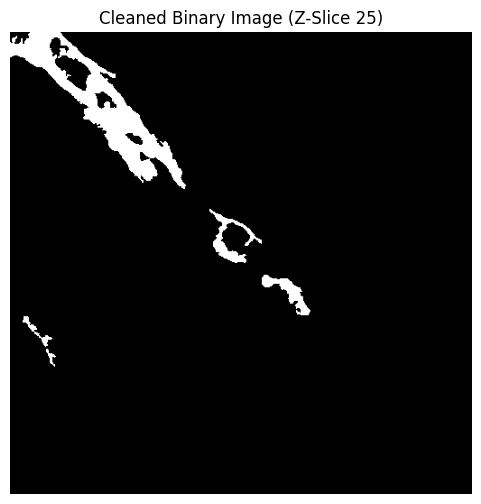

In [20]:
# Remove small objects and fill small holes
cleaned_image = morphology.remove_small_objects(binary_image, min_size=64)
cleaned_image = morphology.remove_small_holes(cleaned_image, area_threshold=64)

# Plot the cleaned binary image
plt.figure(figsize=(6, 6))
plt.imshow(cleaned_image, cmap='gray')
plt.title(f"Cleaned Binary Image (Z-Slice {z_slice_index})")
plt.axis('off')
plt.show()

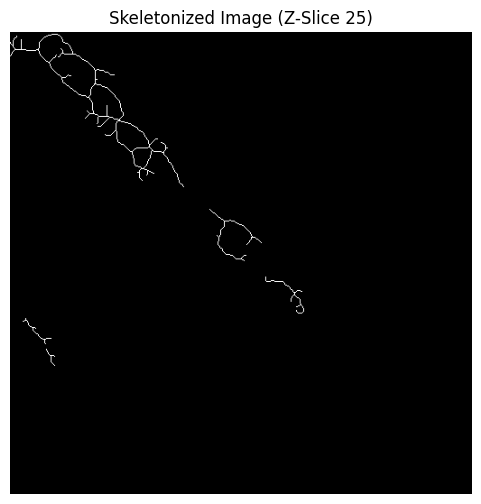

In [21]:
# Skeletonize the 2D cleaned image
skeleton_2d = morphology.skeletonize(cleaned_image)

# Plot the skeletonized image
plt.figure(figsize=(6, 6))
plt.imshow(skeleton_2d, cmap='gray')
plt.title(f"Skeletonized Image (Z-Slice {z_slice_index})")
plt.axis('off')
plt.show()

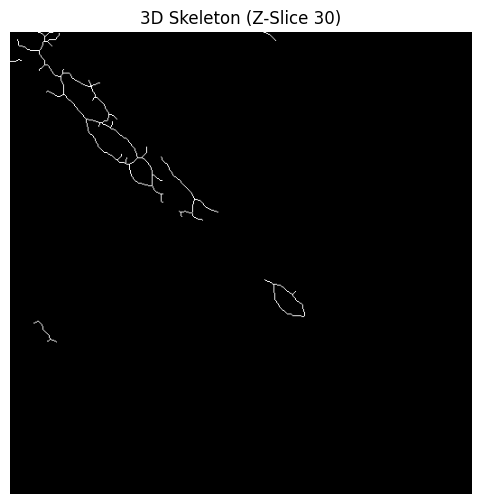

In [23]:
# Process each Z-slice
processed_stack = []
for z in range(num_z_slices):
    # Extract the z-th slice
    z_slice = series.get_frame(z=z, t=0, c=0)
    
    # Apply Gaussian filtering
    smoothed_slice = gaussian_filter(z_slice, sigma=1)
    
    # Apply thresholding
    threshold_value = filters.threshold_otsu(smoothed_slice)
    binary_image = smoothed_slice > threshold_value
    
    # Clean the binary image
    cleaned_image = morphology.remove_small_objects(binary_image, min_size=64)
    cleaned_image = morphology.remove_small_holes(cleaned_image, area_threshold=64)
    
    # Skeletonize the image
    skeleton_2d = morphology.skeletonize(cleaned_image)
    
    # Append to stack
    processed_stack.append(skeleton_2d)

# Convert list to 3D numpy array
processed_stack = np.stack(processed_stack)

# Plot a slice from the 3D skeleton
plt.figure(figsize=(6, 6))
plt.imshow(processed_stack[30], cmap='gray')
plt.title(f"3D Skeleton (Z-Slice {30})")
plt.axis('off')
plt.show()


In [29]:
# Temporary patch for np.float_ deprecation in NumPy 2.0
if not hasattr(np, 'float_'):
    np.float_ = np.float64  # Redirect np.float_ to np.float64
    
from skan import summarize  # Make sure to import summarize
# Create a Skeleton object from the 3D processed stack
skeleton_object = Skeleton(processed_stack)

# Get branch data using summarize
branch_data = summarize(skeleton_object)

# Show the first few rows of branch data to inspect
branch_data.head()

,skeleton-id,node-id-src,node-id-dst,branch-distance,branch-type,mean-pixel-value,stdev-pixel-value,image-coord-src-0,image-coord-src-1,image-coord-src-2,image-coord-dst-0,image-coord-dst-1,image-coord-dst-2,coord-src-0,coord-src-1,coord-src-2,coord-dst-0,coord-dst-1,coord-dst-2,euclidean-distance
0,0,1,118,2.414214,2,1.0,0.0,0,0,449,1,0,449,0,0,449,1,0,449,1.000000
1,0,1,3,2.414214,2,1.0,0.0,0,0,449,0,1,451,0,0,449,0,1,451,2.236068
2,0,1,118,1.000000,2,1.0,0.0,0,0,449,1,0,449,0,0,449,1,0,449,1.000000
3,0,3,4,1.000000,2,1.0,0.0,0,1,451,0,1,452,0,1,451,0,1,452,1.000000
4,0,3,120,1.000000,2,1.0,0.0,0,1,451,1,1,451,0,1,451,1,1,451,1.000000


In [35]:
import pandas as pd
# Extract the coordinates of start and end points using the correct columns
start_coords = branch_data[['coord-src-0', 'coord-src-1', 'coord-src-2']].to_numpy()
end_coords = branch_data[['coord-dst-0', 'coord-dst-1', 'coord-dst-2']].to_numpy()

# Initialize a list to hold fiber properties
fiber_properties = []

for i in range(len(start_coords)):
    start = tuple(start_coords[i])
    end = tuple(end_coords[i])
    
    # Calculate direction vector
    direction = np.array(end) - np.array(start)
    
    # Calculate length of the fiber
    length = distance.euclidean(start, end)
    
    fiber_properties.append({
        'start': start,
        'end': end,
        'direction': direction,
        'length': length
    })

# Convert to a DataFrame for easier handling
fiber_df = pd.DataFrame(fiber_properties)

# Display the fiber properties
fiber_df[['start', 'end', 'direction', 'length']]


,start,end,direction,length
0,"(0, 0, 449)","(1, 0, 449)","[1, 0, 0]",1.000000
1,"(0, 0, 449)","(0, 1, 451)","[0, 1, 2]",2.236068
2,"(0, 0, 449)","(1, 0, 449)","[1, 0, 0]",1.000000
3,"(0, 1, 451)","(0, 1, 452)","[0, 0, 1]",1.000000
4,"(0, 1, 451)","(1, 1, 451)","[1, 0, 0]",1.000000
...,...,...,...,...
9468,"(40, 200, 168)","(40, 203, 169)","[0, 3, 1]",3.162278
9469,"(40, 203, 169)","(40, 204, 169)","[0, 1, 0]",1.000000
9470,"(40, 203, 195)","(40, 206, 194)","[0, 3, -1]",3.162278
9471,"(40, 205, 170)","(40, 206, 170)","[0, 1, 0]",1.000000
